**Fairness in Spam E-mail Detection**

---



**Objective** : <br>
Using Neural networks to process and transform CSDMC2010_Spam Dataset to create a prediction model. This model must predict if an email is spam or not while considering fairness.


**Preprocessing of the model:**<br>
The first step is to import the dataset into a dataframe.Since the dataset is in email format, we use the eml_parser.<br>

Once we import the data into a dataframe, we use the GeoLocation API to get the country, city and zipcode from the originating IP address.<br>

Then we split the dataset using the sklearn.model_selection 

The next step is to tokenize the text into a readable format by the model. It is important to load the same tokenizer a model was trained with to ensure appropriately tokenized words. Load the DistilBERT tokenizer with the AutoTokenizer because we will eventually train a classifier using a pretrained DistilBERT model.


After training the model, we used it to predict on the test set to get the accuracy and confusion matrix.

**Fairness metrics**<br>
After getting the predicted label, we added it to our original dataset and then found the confusion matrix for each country in our dataset. We used the equality of odds which is a fairness metric that checks if, for any particular label and attribute, a classifier predicts that label equally well for all values of that attribute.

**Import Libraries**

In [ ]:
import json
import pandas as pd
import torch
import torch.nn as nn
import re
import spacy
from collections import Counter,defaultdict
from torchtext.data.utils import get_tokenizer

import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

**Load Dataset**

In [ ]:
#Read label for train data
def read_labels_file():
    spam_filename_index = {}
    with open('/content/sp/SPAMTrain.label') as f:
        for label in f.readlines():
            (spam_indicator, filename) = label.split(" ")  
            spam_filename_index[filename.strip()] = spam_indicator
        return spam_filename_index

spam_filename_dict = read_labels_file()

In [ ]:
#Import datset and create dataframe from the dataset
import datetime
import json
import eml_parser
from email import message_from_file
import pandas as pd


import os

df = pd.DataFrame(columns=['email_from','email_to','email_sub','email_date','email_received_ip','email_content'])

for filename in os.listdir("/content/sp/TRAINING"):
  with open(os.path.join("/content/sp/TRAINING", filename), 'rb') as f:
    try:
      raw_email = f.read()
      ep = eml_parser.EmlParser()
      parsed_eml = ep.decode_email_bytes(raw_email)
      email_sub=parsed_eml['header']['subject'];
      email_from=parsed_eml['header']['from'];
      email_to=parsed_eml['header']['to']
      email_date=parsed_eml['header']['date'];
      email_received_ip=parsed_eml['header']['received_ip'];
      email_content=ep.msg.get_body().get_content()
      df=df.append({
          'email_from':email_from,
          'email_to':email_to,
          'email_sub':email_sub,
          'email_date':email_date,
          'email_received_ip':email_received_ip,
          'email_content': email_content,
          'filename':filename,
          'labels':spam_filename_dict[filename] },ignore_index=True)
    except:
      df.to_pickle("./dr.pkl")
      pass

In [ ]:
#select the first IP address from email_received_ip
df['email_received_ip']=df['email_received_ip'].str[0]

In [ ]:
#Create new columns that will be used to store the output from running the API using the IP Address
df["country_name"]=""
df["city"]=""
df["continent_name"]=""
df["zip"]=""

In [ ]:
#Use the API to get Country, city, continent and Zip .Save the data to csv
import requests
for i in range(102,2549):
    if(df.iloc[i,4].split('.')[0]!='192' or '127'):
        response = requests.get("http://api.ipstack.com/"+df.iloc[i,4]+"?access_key=8f9c2a205e49c7fc153a543710843872")
        print("************",i,"*****************")
        print(response.json())
        df.iloc[i,8]=response.json()["country_name"]
        df.iloc[i,9]=response.json()["city"]
        df.iloc[i,10]=response.json()["continent_name"]
        df.iloc[i,11]=response.json()["zip"]

In [ ]:
#Load the data which contains values for country,city,continent and zip.
df= pd.read_csv("/content/drive/MyDrive/cappart1.csv")

**Preprocess Data**

In [ ]:
#Split the data into X and y
X = df['email_content'].values.tolist()
y = df['labels'].values.tolist()

In [ ]:
#use the model selection to split X and y into train and validation data
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(X,y, test_size=.2)

In [ ]:
#Import pretrained DistilBertTokenizerFast
 
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
#Create torch dataset
class Spam_Email(torch.utils.data.Dataset):
    def __init__(self,encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__ (self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
    
train_dataset = Spam_Email(train_encodings, train_labels)
val_dataset = Spam_Email(val_encodings, val_labels)

 **Fine-tune pretrained**

In [ ]:
#Define Trainer Parameters
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
#Define Trainer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy ='steps',
    eval_steps = 10, # Evaluation and Save happens every 10 steps
    save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
    load_best_model_at_end=True,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

#Train pre-trained model
trainer.train()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,0.718000,0.711382,0.338046,0.000000,0.000000,0.000000
20,0.706300,0.690870,0.401028,0.915254,0.104854,0.188153
30,0.687400,0.661629,0.852185,0.849650,0.943689,0.894204
40,0.650500,0.618399,0.847044,0.836735,0.955340,0.892112
50,0.594000,0.544193,0.844473,0.836177,0.951456,0.890100
60,0.509200,0.453112,0.848329,0.837012,0.957282,0.893116
70,0.373700,0.373550,0.849614,0.843103,0.949515,0.893151
80,0.343200,0.328203,0.857326,0.858156,0.939806,0.897127
90,0.352900,0.291902,0.867609,0.870504,0.939806,0.903828
100,0.202400,0.253920,0.906170,0.916981,0.943689,0.930144


***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Running Evaluation *****
  Num examples = 778
  Batch size = 64
***** Runn

TrainOutput(global_step=585, training_loss=0.1461422957599354, metrics={'train_runtime': 2365.3062, 'train_samples_per_second': 3.945, 'train_steps_per_second': 0.247, 'total_flos': 1235920829460480.0, 'train_loss': 0.1461422957599354, 'epoch': 3.0})

 **Predict**

In [ ]:
#Use the val_dataset created from torch dataset
test_dataset = val_dataset
# Load trained model
model_path = "/content/results/checkpoint-500"
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)


loading configuration file /content/results/checkpoint-500/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file /content/results/checkpoint-500/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/results

In [ ]:
# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 778
  Batch size = 8


In [ ]:
#Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1) 

#true label
y_true = val_labels

In [ ]:
#print metrics for the model for the dataset
#Accuracy
accuracy = accuracy_score(y_true, y_pred)
#Recall
recall = recall_score(y_true, y_pred)
#Precision
precision = precision_score(y_true, y_pred)
#F1
f1 = f1_score(y_true, y_pred)
print(accuracy)
print(recall)
print(precision)
print(f1)   

0.9820051413881749
0.9786407766990292
0.9940828402366864
0.9863013698630136


In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[260,   3],
       [ 11, 504]])

In [ ]:
#add the prediction to the dataset
df.loc[:,'predict_close'] = pd.Series(y_pred)

**Fairness Metrics**

In [ ]:
#Drop na in dataset
df5 = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df5.to_csv('final.csv')


In [ ]:
#Function that lists the Confusion matrix for each of the countries
def trythis(country):
  y_ppred=[]
  y_truth=[]
  for u,v in df5.iterrows():
    if v['country_name']==country_name:
      y_ppred.append(v['predict_close'])
      y_truth.append(v['labels'])
  print(country_name)
  print(confusion_matrix(y_truth, y_ppred))


  plt.matshow(confusion_matrix(y_truth, y_ppred), cmap=plt.cm.binary, interpolation='nearest')
  plt.title(country_name)
  plt.colorbar()
  plt.ylabel('expected label')
  plt.xlabel('predicted label')

Spain
[[0 3]
 [0 2]]
Canada
[[ 0  0]
 [ 6 12]]
Switzerland
[[0 1]
 [0 1]]
Brazil
[[3 7]
 [0 0]]
South Korea
[[3 3]
 [0 1]]
Romania
[[0 3]
 [0 0]]
Saudi Arabia
[[2 3]
 [0 0]]
Turkey
[[2]]
Northern Mariana Islands
[[0 1]
 [0 0]]
Vietnam
[[2 3]
 [0 0]]
Thailand
[[0 4]
 [0 0]]
New Zealand
[[3]]
Serbia
[[1]]
France
[[5 1]
 [4 6]]
Tunisia
[[0 1]
 [0 0]]
Mexico
[[1 2]
 [0 0]]
India
[[ 9 10]
 [ 0  1]]
Kazakhstan
[[1 1]
 [0 0]]
Greece
[[0 2]
 [0 0]]
Belgium
[[0 0]
 [3 7]]
Costa Rica
[[2]]
Israel
[[0 2]
 [0 0]]
Russia
[[0 1]
 [0 0]]
China
[[7 8]
 [0 0]]
Taiwan
[[1 3]
 [0 0]]
Argentina
[[1 3]
 [0 0]]
Sri Lanka
[[0 1]
 [0 0]]
Azerbaijan
[[0 1]
 [0 0]]
Italy
[[1 4]
 [0 1]]
Austria
[[0 2]
 [0 4]]
Lithuania
[[0 1]
 [0 0]]
United States
[[ 13  34]
 [ 73 150]]
Ukraine
[[0 1]
 [0 0]]
Australia
[[1 2]
 [1 1]]
Portugal
[[0 1]
 [0 0]]
Guatemala
[[0 1]
 [0 0]]
Finland
[[1]]
United Kingdom
[[4 5]
 [6 9]]
Iran
[[0 1]
 [0 0]]
Germany
[[ 2  3]
 [40 78]]
Japan
[[2 1]
 [0 0]]
Poland
[[5 3]
 [0 0]]
Czechia
[[3]]
I

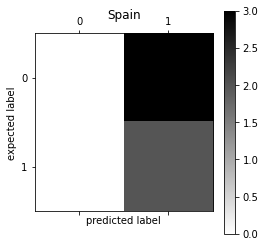

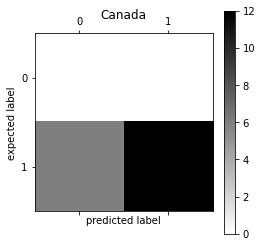

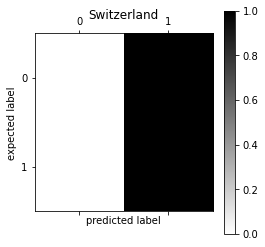

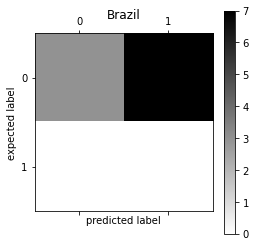

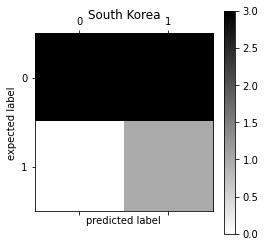

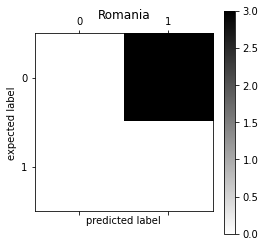

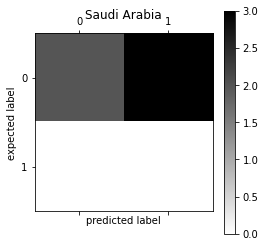

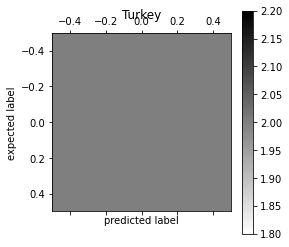

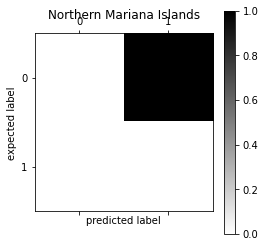

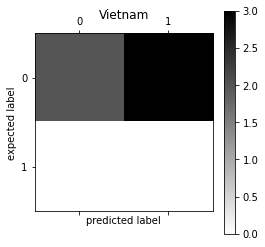

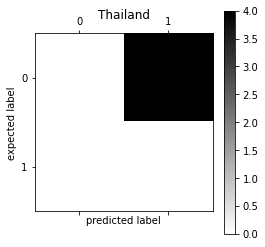

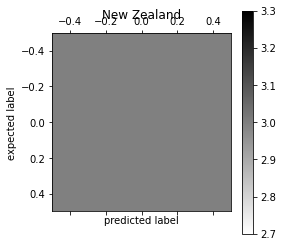

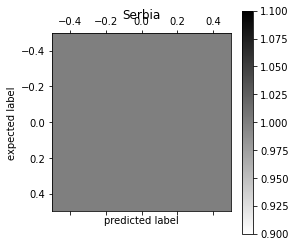

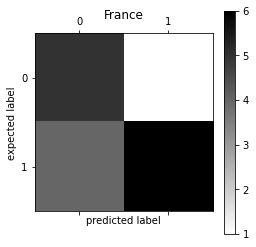

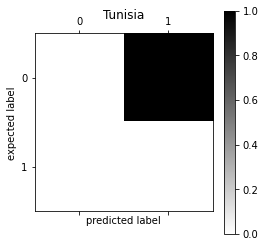

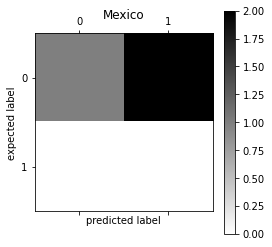

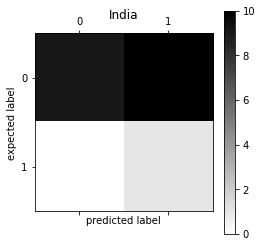

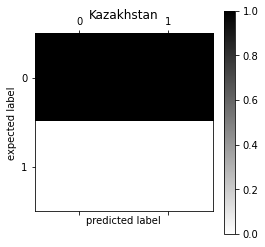

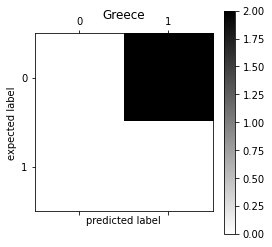

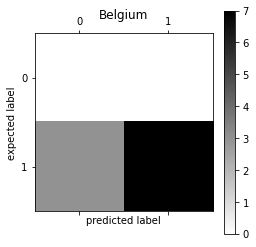

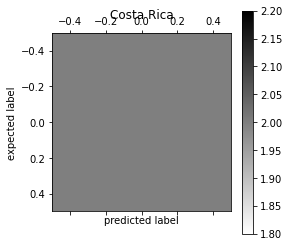

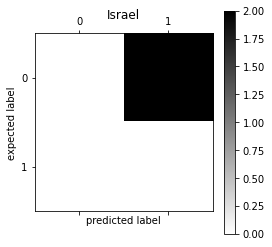

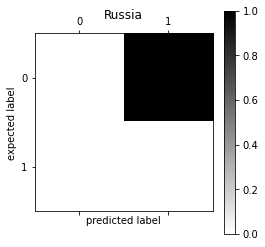

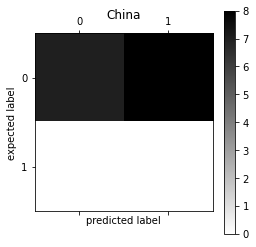

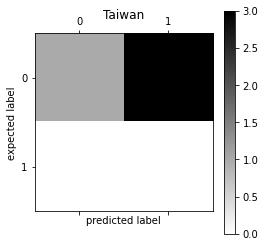

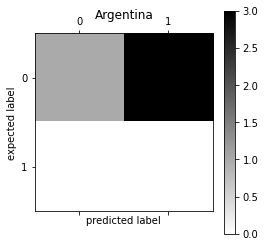

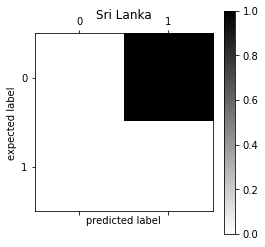

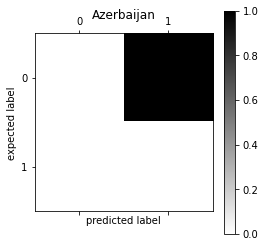

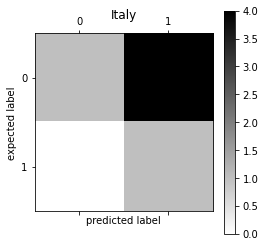

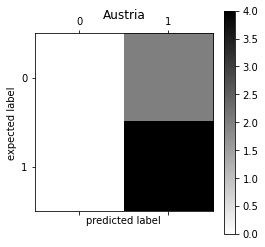

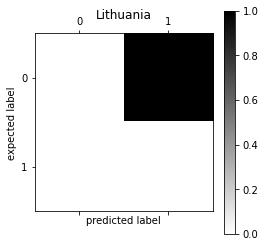

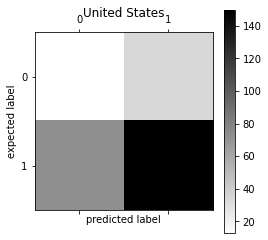

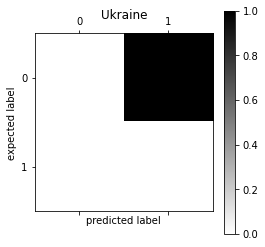

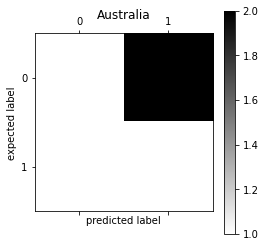

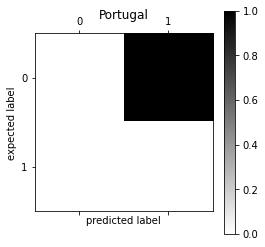

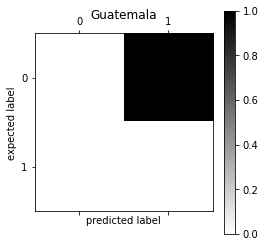

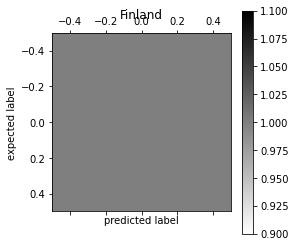

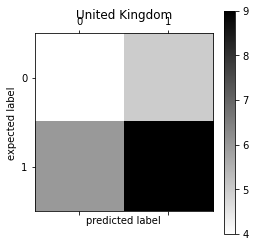

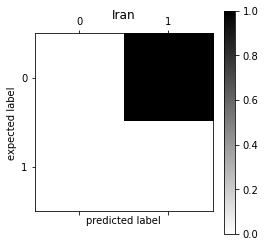

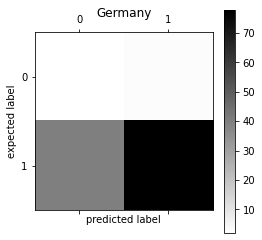

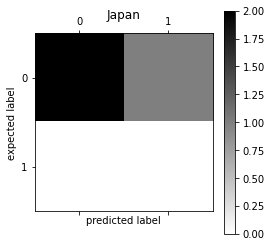

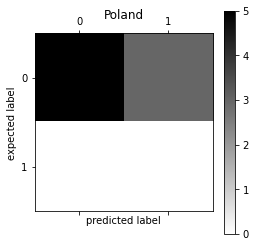

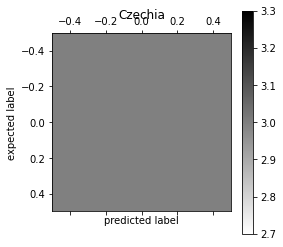

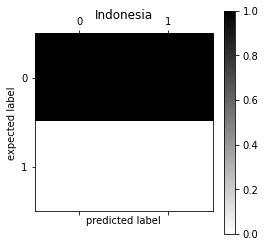

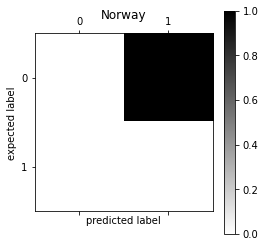

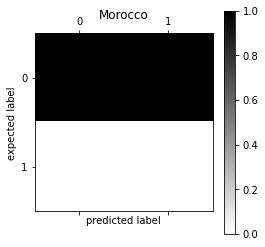

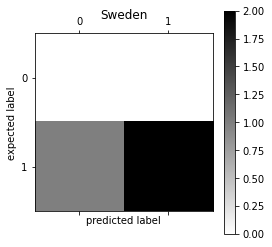

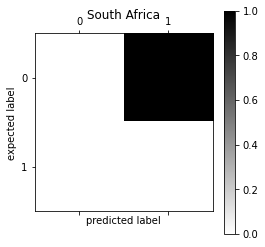

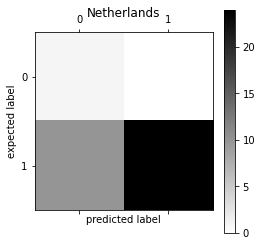

In [ ]:
#Call the function
for country_name in set(df5['country_name']):
  trythis(country_name)

Text(0.5, 0, 'predicted label')

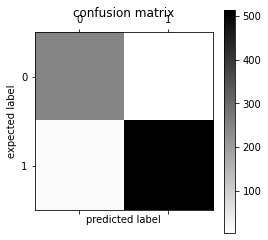

In [ ]:
#Confusion matrix of the whole dataset
plt.matshow(confusion_matrix(y_true, y_pred), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
#Equalized Odds

Fairness = pd.read_csv('/content/drive/MyDrive/Equalized odds.csv')
Fairness.head()

,Unnamed: 0,France,United States,Germany,Australia,United Kingdom
0,Percentage of Spam,55%,15%,4%,50%,40%
1,Percentage of No Spam,85%,81%,96%,33%,64%


This shows the Equality of odds is not satisfied as shown bove because Spam in greater in one country than in the others according to our analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
